# PROJET PHASE 2 - Notebook Modele Energie

## Version finale


## Environnement
Les dependances Python sont gerees via `requirements_phase2.txt`.

In [3]:
# 1. Manipulation des données et système
import os
import sys
import pandas as pd
import numpy as np


# 2. Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Préparation des données (Preprocessing)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4. Modèles (Algorithmes)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 5. Évaluation et Sauvegarde
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# ETAPE 7.0 - Chargement des donnees pour le modele energie


In [4]:
data_pack = joblib.load("model_data_phase2_v2.joblib")

In [5]:
X_fe = data_pack["X_fe"]
y_energy = data_pack["y_energy"]
y_co2 = data_pack["y_co2"]
num_cols = data_pack["num_cols"]
cat_cols = data_pack["cat_cols"]

In [6]:
print("X_fe shape:", X_fe.shape)
print("y_energy shape:", y_energy.shape, "| y_co2 shape:", y_co2.shape)
print("Nb num_cols:", len(num_cols), "| Nb cat_cols:", len(cat_cols))

X_fe shape: (3348, 22)
y_energy shape: (3348,) | y_co2 shape: (3348,)
Nb num_cols: 15 | Nb cat_cols: 6


A cette etape, nous rechargeons les donnees finales preparees dans le notebook general.
Le jeu X_fe contient 3348 lignes et 22 variables explicatives.
Les cibles y_energy et y_co2 sont bien alignees avec ces lignes.


# ETAPE 7.1 - Decoupage train et test


In [7]:



X_train, X_test, y_train_energy, y_test_energy = train_test_split(
    X_fe,
    y_energy,
    test_size=0.2,
    random_state=42
)



In [8]:
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train_energy:", y_train_energy.shape, "| y_test_energy:", y_test_energy.shape)


X_train: (2678, 22) | X_test: (670, 22)
y_train_energy: (2678,) | y_test_energy: (670,)


Nous separons les donnees en train et test pour evaluer le modele sur des batiments non vus.
Le decoupage 80/20 donne 2678 lignes pour le train et 670 lignes pour le test.
Le pretraitement est appris uniquement sur le train pour eviter la fuite d information.


Le decoupage train/test est globalement representatif.
Il reste quelques ecarts sur certaines categories et sur les valeurs extremes.
Ces ecarts peuvent augmenter la difference entre les scores train et test.


# ETAPE 7.2a - Taux de valeurs manquantes


In [9]:

missing_rate = X_fe.isna().mean().sort_values(ascending=False)
print(missing_rate[missing_rate > 0])


SecondLargestPropertyUseType    0.499104
ENERGYSTARScore                 0.244026
GFA_per_floor                   0.004779
LargestPropertyUseType          0.003286
LargestPropertyUseTypeGFA       0.003286
dtype: float64


L’audit des valeurs manquantes sur le jeu de features final montre que les manques ne sont pas uniformes : SecondLargestPropertyUseType est manquant dans environ 49,9 % des cas (absence très fréquente d’un second usage), ENERGYSTARScore dans environ 24,4 % des cas, tandis que les autres manques sont faibles (GFA_per_floor ≈ 0,48 %, LargestPropertyUseType et LargestPropertyUseTypeGFA ≈ 0,33 %). Cette structure indique que certains manques sont potentiellement informatifs (notamment l’absence de second usage) et qu’une stratégie d’imputation doit à la fois (i) éviter d’inventer une information inexistante et (ii) permettre au modèle de tirer parti du fait qu’une valeur est manquante.

# ETAPE 7.2c - Stratification des classes rares


In [10]:
X_tmp = X_fe.copy()

In [11]:
# 1. On compte combien de fois chaque type de bâtiment apparaît
counts = X_tmp["BuildingType"].value_counts()

In [12]:

# 2. On identifie ceux qui n'apparaissent qu'une seule fois
rare_types = counts[counts < 2].index 
major = counts.idxmax()

In [13]:
# 3. On crée une colonne de "stratification" propre :
# On remplace les rares par le type le plus fréquent
strat = X_tmp["BuildingType"].copy()
for t in rare_types:
    strat = strat.replace(t, major)

In [14]:

print("Classe majoritaire utilisée pour fusion :", major)
print("Types rares fusionnés :", list(rare_types))
print("Effectifs strat (min) :", strat.value_counts().min())

Classe majoritaire utilisée pour fusion : NonResidential
Types rares fusionnés : ['Nonresidential WA']
Effectifs strat (min) : 24


In [15]:
# 4. Le découpage (Split)
X_train, X_test, y_train_energy, y_test_energy = train_test_split(
    X_tmp,
    y_energy,
    test_size=0.2,
    random_state=42,
    stratify=strat
)

In [16]:
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train_energy:", y_train_energy.shape, "| y_test_energy:", y_test_energy.shape)


X_train: (2678, 22) | X_test: (670, 22)
y_train_energy: (2678,) | y_test_energy: (670,)


In [17]:

print("\nRépartition BuildingType (train):")
print(X_train["BuildingType"].value_counts(normalize=True).round(4))


Répartition BuildingType (train):
BuildingType
NonResidential          0.4350
Multifamily LR (1-4)    0.3013
Multifamily MR (5-9)    0.1733
Multifamily HR (10+)    0.0329
Nonresidential COS      0.0254
SPS-District K-12       0.0250
Campus                  0.0071
Name: proportion, dtype: float64


In [18]:

print("\nRépartition BuildingType (test):")
print(X_test["BuildingType"].value_counts(normalize=True).round(4))


Répartition BuildingType (test):
BuildingType
NonResidential          0.4328
Multifamily LR (1-4)    0.3015
Multifamily MR (5-9)    0.1731
Multifamily HR (10+)    0.0328
SPS-District K-12       0.0254
Nonresidential COS      0.0254
Campus                  0.0075
Nonresidential WA       0.0015
Name: proportion, dtype: float64


Apres ajustement des classes rares pour la stratification,
la repartition des types de batiments est quasi identique entre train et test.
Le decoupage est donc plus propre pour comparer les modeles.


# ETAPE 7.3 - Preparation des donnees


In [19]:
# On remplace les vides par la médiane et on normalise (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

In [20]:
#  Préparation pour les colonnes CATÉGORIELLES
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [21]:
#  Nous combinons le tout dans un seul objet "preprocessor"
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [22]:
print("Préprocesseur prêt (neutral + missing-as-info).")
print("num_cols:", len(num_cols), "| cat_cols:", len(cat_cols))

Préprocesseur prêt (neutral + missing-as-info).
num_cols: 15 | cat_cols: 6


Nous appliquons un pretraitement simple et clair.
Numeriques : imputation mediane + indicateur de valeur manquante.
Categorielles : imputation 'Missing' puis encodage One-Hot.
Ce choix limite le biais et reste facile a expliquer au jury.


# ETAPE 8.1 - Modele de reference energie


In [23]:



y_pred_base = np.full(shape=len(y_test_energy), fill_value=float(y_train_energy.mean()))

mse_base  = mean_squared_error(y_test_energy, y_pred_base)
rmse_base = float(np.sqrt(mse_base))
mae_base  = mean_absolute_error(y_test_energy, y_pred_base)
r2_base   = r2_score(y_test_energy, y_pred_base)

print("=== Baseline (moyenne) — Énergie (test) ===")
print(f"Test RMSE : {rmse_base:,.2f}")
print(f"Test MAE  : {mae_base:,.2f}")
print(f"Test R²   : {r2_base:,.3f}")


=== Baseline (moyenne) — Énergie (test) ===
Test RMSE : 16,510,567.42
Test MAE  : 5,862,486.79
Test R²   : -0.000


Le modele de reference predit une valeur constante egale a la moyenne du train.
Il sert de point de comparaison minimal.
Tous les modeles supervises doivent faire mieux que ce niveau.


# ETAPE 8.2 - Modele energie : Ridge


In [24]:



ridge = Ridge(alpha=1.0, random_state=42)

model_ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", ridge)
])

model_ridge.fit(X_train, y_train_energy)

pred_train = model_ridge.predict(X_train)
pred_test  = model_ridge.predict(X_test)

rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = mean_absolute_error(y_train_energy, pred_train)
r2_train   = r2_score(y_train_energy, pred_train)

rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = mean_absolute_error(y_test_energy, pred_test)
r2_test   = r2_score(y_test_energy, pred_test)

print("=== Ridge — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:,.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:,.3f}")


=== Ridge — Énergie ===
Train RMSE : 8,673,293.39 | MAE : 3,477,610.65 | R² : 0.855
Test  RMSE : 7,463,900.51 | MAE : 3,621,429.86 | R² : 0.796


Ridge ameliore nettement le modele de reference.
Le score test est bon et l ecart train/test reste raisonnable.
Ce modele est simple, stable et facile a justifier.


# ETAPE 8.3 - Validation croisee sur Ridge
Objectif : verifier la stabilite du modele sur plusieurs decoupages.


In [25]:



cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    model_ridge,         
    X_fe,                 
    y_energy,             
    cv=cv,
    scoring=["r2", "neg_mean_squared_error"],
    n_jobs=-1
)

r2 = scores["test_r2"]
rmse = np.sqrt(-scores["test_neg_mean_squared_error"])

print("CV Ridge (5-fold) — Énergie")
print(f"R²   : mean={r2.mean():.3f} | std={r2.std():.3f} | folds={np.round(r2, 3)}")
print(f"RMSE : mean={rmse.mean():,.0f} | std={rmse.std():,.0f} | folds={np.round(rmse, 0)}")


CV Ridge (5-fold) — Énergie
R²   : mean=0.627 | std=0.180 | folds=[0.45  0.869 0.435 0.575 0.808]
RMSE : mean=10,897,157 | std=3,315,240 | folds=[14603744. 12748982. 13179033.  6016798.  7937230.]


La validation croisee montre une performance correcte,
mais variable selon les decoupages.
Les outliers et la diversite des batiments expliquent cette variabilite.


In [26]:

[c for c in globals().keys() if "preprocess" in c.lower()]


['preprocessor']

# ETAPE 9.1 - Modele energie : RandomForest
Objectif : tester un modele non lineaire avec le meme pretraitement.


In [27]:




rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

model_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

model_rf.fit(X_train, y_train_energy)

pred_train = model_rf.predict(X_train)
pred_test  = model_rf.predict(X_test)

rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = float(mean_absolute_error(y_train_energy, pred_train))
r2_train   = float(r2_score(y_train_energy, pred_train))

rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

print("=== RandomForest — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")


=== RandomForest — Énergie ===
Train RMSE : 6,766,099.27 | MAE : 875,978.19 | R² : 0.912
Test  RMSE : 8,173,358.99 | MAE : 2,213,587.00 | R² : 0.755


RandomForest donne un tres bon score sur train,
mais la baisse sur test montre un debut de surapprentissage.
Le gain par rapport a Ridge reste limite sur ce dataset.


# ETAPE 9.2 - Modele energie : GradientBoostingRegressor


In [28]:
gbr = GradientBoostingRegressor(random_state=42)

model_gbr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gbr)
])

In [29]:


model_gbr.fit(X_train, y_train_energy)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [30]:

pred_train = model_gbr.predict(X_train)
pred_test  = model_gbr.predict(X_test)

In [31]:

rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = float(mean_absolute_error(y_train_energy, pred_train))
r2_train   = float(r2_score(y_train_energy, pred_train))

In [32]:

rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

In [33]:
print("=== GradientBoosting — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")

=== GradientBoosting — Énergie ===
Train RMSE : 2,793,395.81 | MAE : 1,406,336.62 | R² : 0.985
Test  RMSE : 7,863,426.58 | MAE : 2,327,870.66 | R² : 0.773


GradientBoosting suit la meme tendance :
tres bon train, mais gain test plus modere.
Le modele capte bien le train, mais generalise moins bien que prevu.


# ETAPE 9.3b - Modele energie : XGBoost


In [34]:

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

In [35]:

model_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb)
])

In [36]:

model_xgb.fit(X_train, y_train_energy)

pred_train = model_xgb.predict(X_train)
pred_test  = model_xgb.predict(X_test)

In [37]:
rmse_train = float(np.sqrt(mean_squared_error(y_train_energy, pred_train)))
mae_train  = float(mean_absolute_error(y_train_energy, pred_train))
r2_train   = float(r2_score(y_train_energy, pred_train))

In [38]:
rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

In [39]:

print("=== XGBoost — Énergie ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")


=== XGBoost — Énergie ===
Train RMSE : 553,229.21 | MAE : 391,706.81 | R² : 0.999
Test  RMSE : 7,299,144.53 | MAE : 2,039,672.98 | R² : 0.805


XGBoost donne de bons resultats sur test,
mais l ecart train/test invite a rester prudent sans controle supplementaire.
La validation croisee aide a confirmer ce point.


# ETAPE 9.3c - Validation croisee sur XGBoost


In [40]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    model_xgb,  
    X_fe,
    y_energy,
    cv=cv,
    scoring=["r2", "neg_mean_squared_error"],
    n_jobs=-1
)

In [41]:
r2 = scores["test_r2"]
rmse = np.sqrt(-scores["test_neg_mean_squared_error"])

print("CV XGBoost (5-fold) — Énergie")
print(f"R²   : mean={r2.mean():.3f} | std={r2.std():.3f} | folds={np.round(r2, 3)}")
print(f"RMSE : mean={rmse.mean():,.0f} | std={rmse.std():,.0f} | folds={np.round(rmse, 0)}")


CV XGBoost (5-fold) — Énergie
R²   : mean=0.582 | std=0.239 | folds=[0.423 0.211 0.62  0.821 0.837]
RMSE : mean=13,649,476 | std=9,542,745 | folds=[14956961. 31267102. 10810382.  3905114.  7307819.]


La validation croisee de XGBoost montre des resultats variables selon les plis.
Le modele peut etre tres bon sur certains plis et plus faible sur d autres.
On retient donc une version avec arret anticipe pour mieux controler l apprentissage.


# ETAPE 9.4 - Modele energie : XGBoost avec early stopping


In [42]:


X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_energy,
    test_size=0.2,
    random_state=42,
    stratify=X_train["BuildingType"]
)

In [43]:
xgb_es = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=5.0,     
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

In [44]:



X_tr_p = preprocessor.fit_transform(X_tr)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)


In [45]:

xgb_es.fit(
    X_tr_p, y_tr,
    eval_set=[(X_val_p, y_val)],
    verbose=False
)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_method

In [46]:

pred_test = xgb_es.predict(X_test_p)

In [47]:
rmse_test = float(np.sqrt(mean_squared_error(y_test_energy, pred_test)))
mae_test  = float(mean_absolute_error(y_test_energy, pred_test))
r2_test   = float(r2_score(y_test_energy, pred_test))

In [48]:
print("=== XGBoost (early stopping) — Énergie (test) ===")
print(f"Test RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")
print("Best iteration:", getattr(xgb_es, "best_iteration", None)) 

=== XGBoost (early stopping) — Énergie (test) ===
Test RMSE : 6,339,430.52 | MAE : 1,950,426.39 | R² : 0.853
Best iteration: 1243


Avec early stopping, XGBoost devient le meilleur modele energie sur le test.
Le modele s arrete a la meilleure iteration de validation,
ce qui evite de continuer inutilement et limite le surapprentissage.


# ETAPE 9.5 - Courbe d apprentissage XGBoost


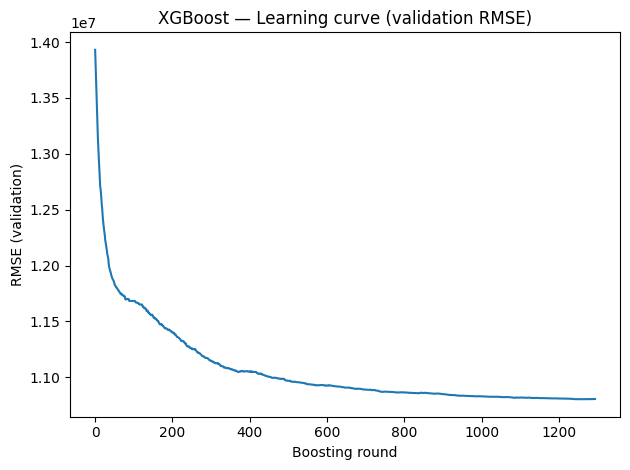

best_iteration: 1243
best_score: 10804429.747569263


In [49]:
results = xgb_es.evals_result()
rmse_val = results["validation_0"]["rmse"]

plt.figure()
plt.plot(rmse_val)
plt.xlabel("Boosting round")
plt.ylabel("RMSE (validation)")
plt.title("XGBoost — Learning curve (validation RMSE)")
plt.tight_layout()
plt.show()

print("best_iteration:", getattr(xgb_es, "best_iteration", None))
print("best_score:", getattr(xgb_es, "best_score", None))


La courbe de RMSE sur le jeu de validation montre une diminution rapide au début de l'entrainement, suivie d'une phase de stabilisation progressive. Cette dynamique indique que le modèle capture efficacement les relations principales dès les premières itérations, puis affine les prédictions sans dégradation des performances sur les données de validation. Le plateau observé après environ 1200 itérations suggère que les arbes supplémentaires apportent peu de gain, ce qui justifie l'utilisation de l'early stopping pour limiter la complexité du modèle. L'absence de remontée du RMSE valide l'absence de surapprentissage sévère et confirme une bonne capacité de généralisation du modèle retenu.

In [50]:
results = xgb_es.evals_result()
rmse_val = results["validation_0"]["rmse"]
best_iter = getattr(xgb_es, "best_iteration", None) 

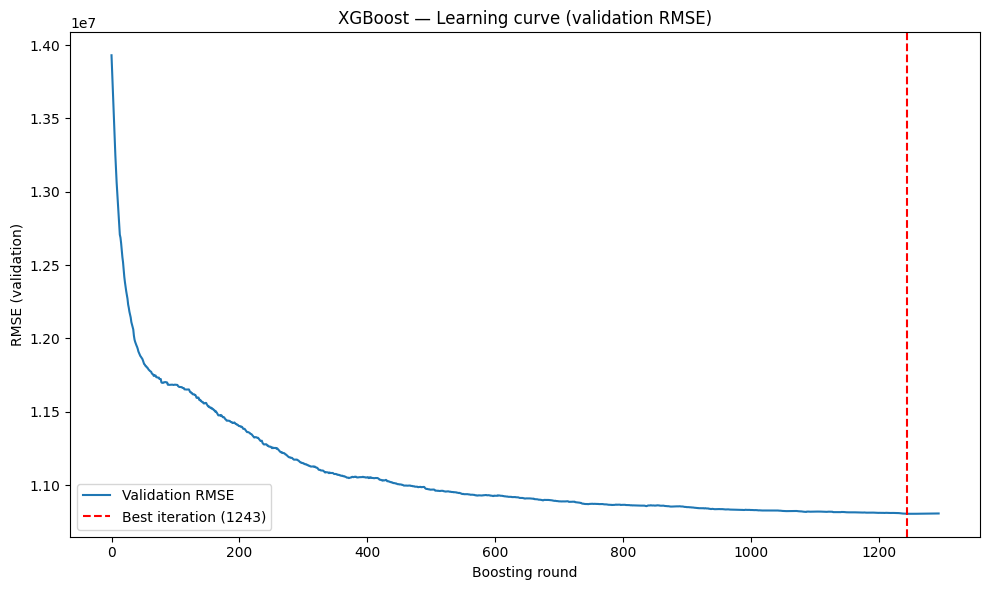

best_iteration: 1243
best_score: 10804429.747569263


In [51]:


plt.figure(figsize=(10, 6))
plt.plot(rmse_val, label="Validation RMSE")


if best_iter is not None:
    plt.axvline(best_iter, color='r', linestyle='--', label=f'Best iteration ({best_iter})')


plt.xlabel("Boosting round")
plt.ylabel("RMSE (validation)")
plt.title("XGBoost — Learning curve (validation RMSE)")
plt.legend() 
plt.tight_layout()
plt.show()


print("best_iteration:", best_iter)
print("best_score:", getattr(xgb_es, "best_score", None))

# ETAPE 10.0 - Validation finale energie

Cette section applique un protocole clair :
- decoupage train/test une seule fois
- decoupage train/validation pour le choix du modele
- evaluation finale unique sur le test


In [1]:
import numpy as np
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def safe_stratify(series):
    counts = series.value_counts()
    major = counts.idxmax()
    rare = counts[counts < 2].index
    return series.where(~series.isin(rare), major)


pack = joblib.load('model_data_phase2_v2.joblib')
X_fe = pack['X_fe'].copy()
y_energy = pack['y_energy']
num_cols = pack['num_cols']
cat_cols = pack['cat_cols']

strat_all = safe_stratify(X_fe['BuildingType'])
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_fe,
    y_energy,
    test_size=0.2,
    random_state=42,
    stratify=strat_all,
)

strat_train = safe_stratify(X_train_full['BuildingType'])
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=strat_train,
)

num_used = [c for c in num_cols if c in X_fe.columns]
cat_used = [c for c in cat_cols if c in X_fe.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
            ('scaler', StandardScaler())
        ]), num_used),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_used),
    ]
)

X_train_p = preprocessor.fit_transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)

dtrain = xgb.DMatrix(X_train_p, label=y_train)
dval = xgb.DMatrix(X_val_p, label=y_val)
dtest = xgb.DMatrix(X_test_p)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 5.0,
    'seed': 42,
}

evals_result = {}
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=False,
)

pred_val = bst.predict(dval)
pred_test = bst.predict(dtest)

baseline_val = np.full(len(y_val), y_train.mean())
baseline_test = np.full(len(y_test), y_train.mean())


def score(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

rmse_val, mae_val, r2_val = score(y_val, pred_val)
rmse_test, mae_test, r2_test = score(y_test, pred_test)
rmse_bv, mae_bv, r2_bv = score(y_val, baseline_val)
rmse_bt, mae_bt, r2_bt = score(y_test, baseline_test)

print('=== Energie - Validation finale ===')
print('Split:', {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)})
print(f'Best iteration: {bst.best_iteration} | Best val RMSE: {min(evals_result["val"]["rmse"]):,.2f}')
print(f'MODEL VAL  -> RMSE: {rmse_val:,.2f} | MAE: {mae_val:,.2f} | R2: {r2_val:.3f}')
print(f'MODEL TEST -> RMSE: {rmse_test:,.2f} | MAE: {mae_test:,.2f} | R2: {r2_test:.3f}')
print(f'BASE  VAL  -> RMSE: {rmse_bv:,.2f} | MAE: {mae_bv:,.2f} | R2: {r2_bv:.3f}')
print(f'BASE  TEST -> RMSE: {rmse_bt:,.2f} | MAE: {mae_bt:,.2f} | R2: {r2_bt:.3f}')


=== Energie - Validation finale ===
Split: {'train': 2142, 'val': 536, 'test': 670}
Best iteration: 1243 | Best val RMSE: 10,804,429.75
MODEL VAL  -> RMSE: 10,805,018.47 | MAE: 1,976,923.35 | R2: 0.415
MODEL TEST -> RMSE: 6,342,842.32 | MAE: 1,955,957.58 | R2: 0.852
BASE  VAL  -> RMSE: 14,143,223.13 | MAE: 5,494,543.34 | R2: -0.002
BASE  TEST -> RMSE: 16,511,086.85 | MAE: 5,948,498.15 | R2: -0.000


## ETAPE 10.1 - Importance des variables energie


In [2]:
import pandas as pd

feat_names = preprocessor.get_feature_names_out()
imp = bst.get_score(importance_type="gain")

rows = []
for k, v in imp.items():
    idx = int(k[1:])
    rows.append((feat_names[idx], v))

fi_energy = (pd.DataFrame(rows, columns=["feature", "gain"])
               .sort_values("gain", ascending=False)
               .reset_index(drop=True))

print("Nb features avec importance non nulle:", fi_energy.shape[0])
print("Top 10 features energie:")
display(fi_energy.head(10))


Nb features avec importance non nulle: 135
Top 10 features energie:


,feature,gain
0,cat__BuildingType_Campus,6.466042e+15
1,num__NumberofBuildings,3.107241e+15
2,num__LargestPropertyUseTypeGFA,2.109214e+15
3,cat__PrimaryPropertyType_Hospital,1.125756e+15
4,cat__LargestPropertyUseType_Hospital (General ...,5.260478e+14
5,num__Longitude,4.864601e+14
6,cat__SecondLargestPropertyUseType_Movie Theater,4.785753e+14
7,cat__SecondLargestPropertyUseType_Laboratory,3.246282e+14
8,num__NumberofFloors,3.047994e+14
9,cat__LargestPropertyUseType_Multifamily Housing,2.919663e+14


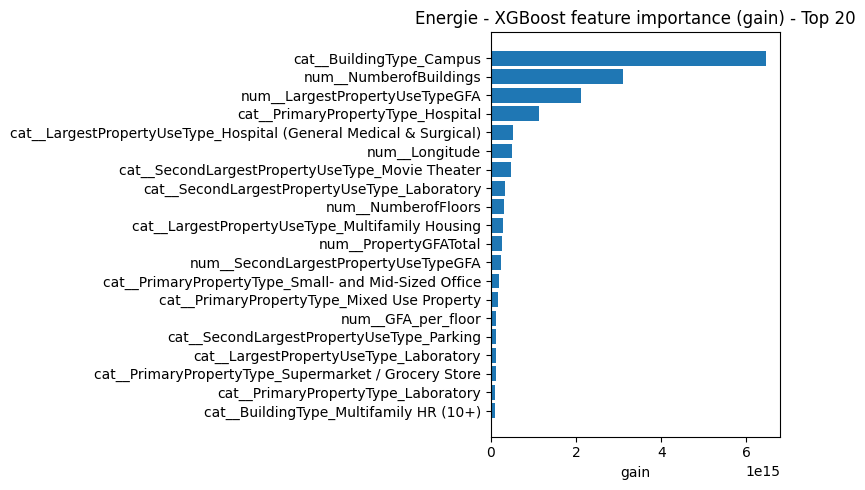

In [3]:
import matplotlib.pyplot as plt

top = fi_energy.head(20).iloc[::-1]
plt.figure(figsize=(8, 5))
plt.barh(top["feature"], top["gain"])
plt.title("Energie - XGBoost feature importance (gain) - Top 20")
plt.xlabel("gain")
plt.ylabel("")
plt.tight_layout()
plt.show()


Ce graphique montre les 20 variables les plus influentes pour pr?dire l??nergie. Plus la barre est longue, plus la variable influence la d?cision du mod?le. On voit que le type de b?timent et la taille du b?timent dominent la pr?diction : par exemple BuildingType_Campus, NumberofBuildings, LargestPropertyUseTypeGFA et NumberofFloors. Donc, le mod?le s?appuie surtout sur des facteurs m?tier coh?rents : usage du b?timent, surface et volume du parc.
